**Esse notebook descreve um programa para fazer a reconstrucao 3D de órgãos humanos, cada bloco de codigo ocorre separadamente e representa um programa idependente.**

---


Trabalho desenvolvido por: Danna Katherine Nieto Huegas, Nicole Schmid e Leonardo Jose


---
<br>**OBS**: Lembrar de atualizar o destino das pastas do drive para funcionar o codigo<br/>
<br>**OBS**: Utilizar GPU do colab deixa o processo mais rapido<br/>



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


O bloco de codigo abaixo representa a logica para limpar o ruido da imagem.

<ipython-input-13-4b696dfa4552>:17: FutureWarning:

`multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.



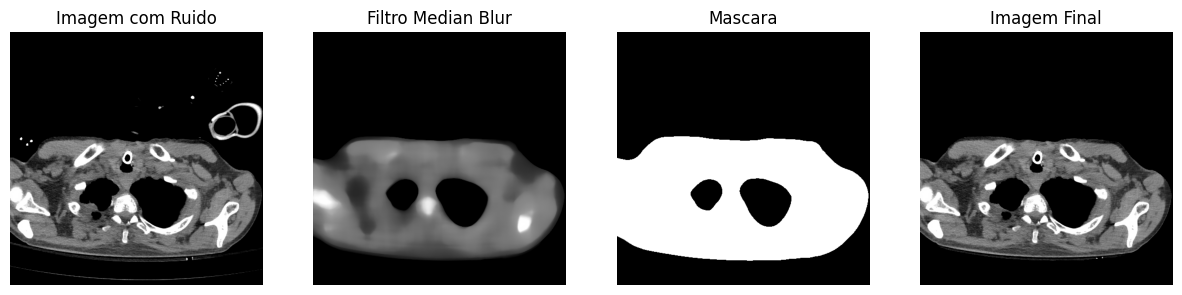

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

from skimage import feature
from skimage import data, exposure

image = cv2.imread('/content/drive/MyDrive/data/pulmonar_image_10.jpeg')

###limpar o ruido das imagens
blur_image =cv2.medianBlur(image, 41)
threshold_value = 15
_,mask = cv2.threshold(blur_image, threshold_value, 255, cv2.THRESH_BINARY)
filtered_image = cv2.multiply(image, (mask//255))
###

fd, hog_image = feature.hog(filtered_image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 9), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Imagem com Ruido')

ax2.axis('off')
ax2.imshow(blur_image, cmap=plt.cm.gray)
ax2.set_title('Filtro Median Blur')

ax3.axis('off')
ax3.imshow(mask, cmap=plt.cm.gray)
ax3.set_title('Mascara')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax4.axis('off')
ax4.imshow(filtered_image, cmap=plt.cm.gray)
ax4.set_title('Imagem Final')

plt.show()

O bloco de codigo abaixo representa a logica para encontrar e isolar o segmento que representa o contorno do pulmao.

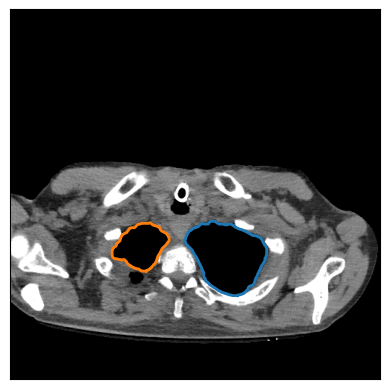

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from PIL import Image, ImageDraw

def contorno_Fechado(contour):
  # Verificar se o contorno está fechado
  primeiro_ponto = contour[0]
  ultimo_ponto = contour[-1]
  # Definir uma tolerância para verificar a proximidade entre o ultimo e o primeiro ponto
  tolerancia = 5
  contorno_fechado = np.allclose(primeiro_ponto, ultimo_ponto, atol=tolerancia)
  return contorno_fechado

def find_lungs(contours):
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        if len(contour) >30:
            contour = np.asarray(contour, dtype=np.float32)
            hull = ConvexHull(contour)
            # Restringir o tamanho dos contornos que representam o pulmao
            if hull.volume > 1500 and hull.volume < 110000 and contorno_Fechado(contour):
                body_and_lung_contours.append(contour)
                vol_contours.append(hull.volume)

    # Discartar os contornos que representam o corpo todo
    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in
                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1)
    return body_and_lung_contours


# Carregue a imagem em escala de cinza
image = cv2.imread('/content/drive/MyDrive/data/pulmonar_image_10.jpeg', cv2.IMREAD_GRAYSCALE)

### Limpar o ruído das imagens
filtered_image = cv2.medianBlur(image, 41)
threshold_value = 15
_, filtered_image = cv2.threshold(filtered_image, threshold_value, 255, cv2.THRESH_BINARY)
filtered_image = cv2.multiply(image, (filtered_image // 255))
###

# Encontre contornos em uma constante de valor 2
contours = measure.find_contours(filtered_image, 2)


# Exiba a imagem e trace todos os contornos encontrados
fig, ax = plt.subplots()
ax.imshow(filtered_image, cmap=plt.cm.gray)

for contour in find_lungs(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

O bloco de codigo abaixo representa como se cria um objeto 3D e visualiza ele no google colab.

In [ ]:
import plotly.graph_objects as go
import numpy as np

""" Atribuir valores a um objeto open3d - nuvem de pontos """
col1=np.asarray([-3,3,-3,3,-3,3,-3,3]) #Linha dos pontos em x
col2=np.asarray([3,3,-3,-3,3,3,-3,-3]) #Linha dos pontos em y
col3=np.asarray([0,0,0,0,6,6,6,6]) #Linha dos pontos em z

#Cria uma matriz de zeros (size(col1) linhas x 3 colunas) e preenche
xyz = np.zeros((np.size(col1), 3))
xyz[:, 0] = np.reshape(col1, -1)
xyz[:, 1] = np.reshape(col2, -1)
xyz[:, 2] = np.reshape(col3, -1)

print("xyz\n",xyz)

colors = None
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2],
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

xyz
 [[-3.  3.  0.]
 [ 3.  3.  0.]
 [-3. -3.  0.]
 [ 3. -3.  0.]
 [-3.  3.  6.]
 [ 3.  3.  6.]
 [-3. -3.  6.]
 [ 3. -3.  6.]]




---


**Programa Final - Criar uma imagem 3D dos ossos com base em imagens 2D**


---



In [ ]:
import cv2
import os
import numpy as np
import plotly.graph_objects as go

def arrayImagensTo3d(arrayImagens, z_scale_mult):
    colXcoordinates, colYcoordinates, colZcoordinates = [], [], []

    for i, img in enumerate(arrayImagens):

        """ Otimizado pelo chat gpt """
        non_zero_indices = np.argwhere(img > 0)
        non_zero_indices = non_zero_indices[:, [1, 0]]  # Inverte as coordenadas x e y

        colXcoordinates.extend(non_zero_indices[:, 0])
        colYcoordinates.extend(non_zero_indices[:, 1])
        colZcoordinates.extend([i * z_scale_mult] * len(non_zero_indices))

        """ Original """
    #for coord_xPixel, linha in enumerate(img):
    #    for coord_yPixel, elemento in enumerate(linha):
    #        if elemento > 0:
    #            colXcoordinates.append(coord_xPixel)
    #            colYcoordinates.append(coord_yPixel)
    #            colZcoordinates.append(i * z_scale_mult)

    colXcoordinates_np = np.array(colXcoordinates)
    colYcoordinates_np = np.array(colYcoordinates)
    colZcoordinates_np = np.array(colZcoordinates)

    xyz = np.column_stack((colXcoordinates_np, colYcoordinates_np, colZcoordinates_np))

    return xyz

# Numero de arquivos de imagem na pasta
path = '/content/drive/MyDrive/data'
num_files = len([f for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f))])
num_files=int(num_files)
# Junta um array com as imagens que serão analisadas
img_grayscale = []
threshold_value = 180  # Valor de limite (ajuste conforme necessário)

for i in range(num_files):
    image = cv2.imread('/content/drive/MyDrive/data/pulmonar_image_'+str(i+1)+'.jpeg', 0)

    ############# OPERACOES DE FILTRAGEM DOS ORGAOS ##############
    #Filtro para limpar o ruido
    filtered_image =cv2.medianBlur(image, 41)
    _,filtered_image = cv2.threshold(filtered_image, 15, 255, cv2.THRESH_BINARY)
    filtered_image = cv2.multiply(image, (filtered_image//255))
    #Filtro de limiar para pegar o branco dos ossos
    _,binary_image = cv2.threshold(filtered_image, threshold_value, 255, cv2.THRESH_BINARY)

    img_grayscale.append(binary_image)
print("Numero de Imagens Capturadas: " + str(len(img_grayscale)))

# Converter a lista img_grayscale em um array NumPy
grayscale = np.array(img_grayscale)

#Aplica a funcao para gerar o 3d
arrayImagens=arrayImagensTo3d(grayscale,3)

#Reduz o numero de pontos na imagem 3d, indica-se utilizar no minimo num_reducoes = 3 para o colab
num_reducoes = 3
arrayImagens_Reducao = arrayImagens
for _ in range(num_reducoes):
    arrayImagens_Reducao = arrayImagens_Reducao[::2]

print("Array Coordenadas Pontos\n",arrayImagens_Reducao)

points = np.asarray(arrayImagens_Reducao)
colors = None
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2],
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

Numero de Imagens Capturadas: 92
Array Coordenadas Pontos
 [[232 230   0]
 [236 231   0]
 [220 237   0]
 ...
 [263 423 273]
 [258 424 273]
 [266 424 273]]


---


**Criar uma imagem 3D do pulmão com base em imagens 2D**


---

In [ ]:
import cv2
import os
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from skimage import measure
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from PIL import Image, ImageDraw

def contorno_Fechado(contour):
  # Verificar se o contorno está fechado
  primeiro_ponto = contour[0]
  ultimo_ponto = contour[-1]
  # Definir uma tolerância para considerar os pontos como iguais
  tolerancia = 5
  contorno_fechado = np.allclose(primeiro_ponto, ultimo_ponto, atol=tolerancia)
  return contorno_fechado

def find_lungs(contours):
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        if len(contour) >30:
            contour = np.asarray(contour, dtype=np.float32)
            hull = ConvexHull(contour)
            # Restringir o tamanho dos contornos que representam o pulmao
            if hull.volume > 1500 and hull.volume < 110000 and contorno_Fechado(contour):
                body_and_lung_contours.append(contour)
                vol_contours.append(hull.volume)

    # Discartar os contornos do corpo todo
    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in
                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1)
    return body_and_lung_contours

def create_mask_from_polygon(image, contours):
    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1
    return lung_mask.T



def arrayImagensTo3d(arrayImagens, z_scale_mult):
    colXcoordinates, colYcoordinates, colZcoordinates = [], [], []

    for i, img in enumerate(arrayImagens):

        """ Otimizado pelo chat gpt """
        non_zero_indices = np.argwhere(img > 0)
        non_zero_indices = non_zero_indices[:, [1, 0]]  # Inverte as coordenadas x e y

        colXcoordinates.extend(non_zero_indices[:, 0])
        colYcoordinates.extend(non_zero_indices[:, 1])
        colZcoordinates.extend([i * z_scale_mult] * len(non_zero_indices))

        """ Original """
    #for coord_xPixel, linha in enumerate(img):
    #    for coord_yPixel, elemento in enumerate(linha):
    #        if elemento > 0:
    #            colXcoordinates.append(coord_xPixel)
    #            colYcoordinates.append(coord_yPixel)
    #            colZcoordinates.append(i * z_scale_mult)

    colXcoordinates_np = np.array(colXcoordinates)
    colYcoordinates_np = np.array(colYcoordinates)
    colZcoordinates_np = np.array(colZcoordinates)

    xyz = np.column_stack((colXcoordinates_np, colYcoordinates_np, colZcoordinates_np))

    return xyz

# Numero de arquivos de imagem na pasta
path = '/content/drive/MyDrive/data'
num_files = len([f for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f))])
num_files=int(num_files)
# Junta um array com as imagens que serão analisadas
img_grayscale = []
threshold_value = 180  # Valor de limite (ajuste conforme necessário)

for i in range(num_files):
    image = cv2.imread('/content/drive/MyDrive/data/pulmonar_image_'+str(i+1)+'.jpeg', 0)

    ############# OPERACOES DE FILTRAGEM DOS ORGAOS ##############
    #Filtro para limpar o ruido
    filtered_image =cv2.medianBlur(image, 41)
    _,filtered_image = cv2.threshold(filtered_image, 15, 255, cv2.THRESH_BINARY)
    filtered_image = cv2.multiply(image, (filtered_image//255))

    #Filtro de limiar para pegar o branco dos ossos

    # Encontre contornos em uma constante de valor 0.8
    contours = measure.find_contours(filtered_image, 2)

    # Exiba a imagem e trace todos os contornos encontrados
    image=create_mask_from_polygon(image, find_lungs(contours))

    img_grayscale.append(image)
print("Numero de Imagens Capturadas: " + str(len(img_grayscale)))

# Converter a lista img_grayscale em um array NumPy
grayscale = np.array(img_grayscale)

#Aplica a funcao para gerar o 3d
arrayImagens=arrayImagensTo3d(grayscale,3)

#Reduz o numero de pontos na imagem 3d, indica-se utilizar no minimo num_reducoes = 3 para o colab
num_reducoes = 4
arrayImagens_Reducao = arrayImagens
for _ in range(num_reducoes):
    arrayImagens_Reducao = arrayImagens_Reducao[::2]

print("Array Coordenadas Pontos\n",arrayImagens_Reducao)

'''
######### Para usar no VScode - No coolab nao funciona o visualization do open3d ##########
import open3d as o3d

#Cria um objeto vazio de nuvem de pontos
pcd_demo = o3d.geometry.PointCloud()
#Transforma o array do numpy para um vetor 3d e transfere para points
pcd_demo.points = o3d.utility.Vector3dVector(arrayImagens_Reducao)
#Visualiza no open 3d
o3d.visualization.draw_geometries([pcd_demo])
o3d.io.write_point_cloud("print_pcd_demo.pcd",pcd_demo)
'''

points = np.asarray(arrayImagens_Reducao)
colors = None
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2],
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

Numero de Imagens Capturadas: 92
Array Coordenadas Pontos
 [[287 318  15]
 [284 320  15]
 [286 321  15]
 ...
 [374 232 273]
 [366 233 273]
 [361 234 273]]
